In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES']='1'
#os.environ['CUDA_VISIBLE_DEVICES']='00000000:81:00.0'

In [2]:
%pylab inline
import jax
import jax.numpy as jnp
import tqdm
import optax
import flax.linen as nn
from flax.metrics import tensorboard
from jax_resnet import resnet
from functools import partial
import numpy as np
import pickle

import pisco
import pisco.datasets
import tensorflow_datasets as tfds

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
# Define our compressor
ResNet = partial(resnet.ResNet18, n_classes=2)

class NeuralCompressor(nn.Module):
  @nn.compact
  def __call__(self, x):
    return ResNet()(x)

In [4]:
# Random seed for sampling from posterior
seed = jax.random.PRNGKey(0)

# Let's instantiate and initialize the model
model = NeuralCompressor()
params = model.init(jax.random.PRNGKey(42), jnp.zeros(shape=[1, 352, 352,1]))

# Define a scheduler for the learning rate
#total_steps = 30_000
total_steps = 3_000
lr_scheduler = optax.piecewise_constant_schedule(init_value=0.001,
                  boundaries_and_scales={int(total_steps*0.3):0.2,
                                         int(total_steps*0.6):0.1,})

# Initializes an optimizer and optimizer state
optimizer = optax.adam(learning_rate=lr_scheduler)
opt_state = optimizer.init(params)

summary_writer = tensorboard.SummaryWriter('logs/euclid_mse_'+str(total_steps))

In [5]:
dset = tfds.load('pisco_euclid',split='train')
# Let's collect a few examples to check their distributions
cutouts=[]
specz = []
for (batch, entry) in enumerate(dset.take(100)):
  cutouts.append(entry['image'])
cutouts = np.stack(cutouts)
cutouts[isnan(cutouts)] = 0

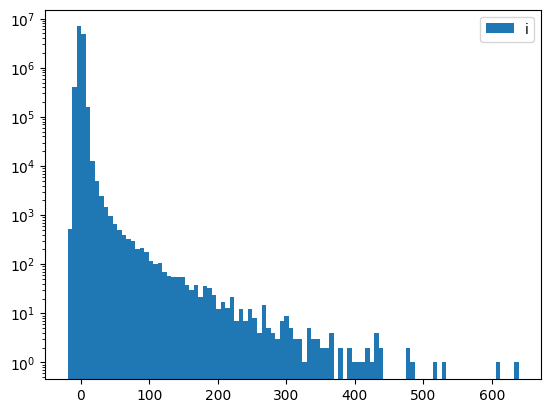

In [6]:
for i,b in enumerate(['i']):
  plt.hist(cutouts[...].flatten(),100, label=b);
plt.legend()
plt.yscale('log')

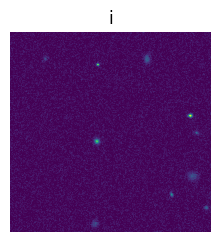

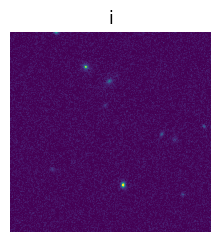

In [7]:
plt.figure(figsize=(15,3))
for i,b in enumerate(['i']):
  plt.subplot(1,5,i+1)
  plt.imshow(cutouts[0,:,:],vmin=-1,vmax=50)
  plt.title(b)
  plt.axis('off')

plt.figure(figsize=(15,3))
for i,b in enumerate(['i']):
  plt.subplot(1,5,i+1)
  plt.imshow(cutouts[1,:,:],vmin=-1,vmax=50)
  plt.title(b)
  plt.axis('off')

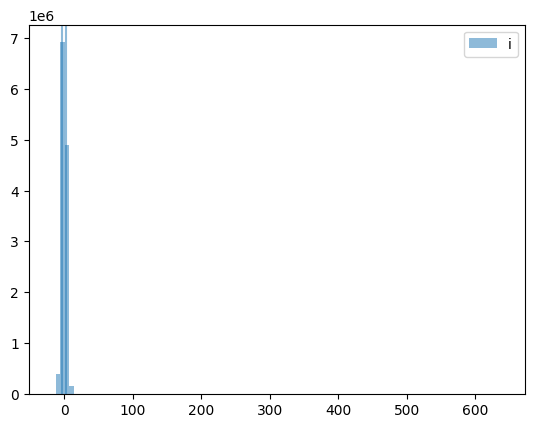

In [8]:
# Let's evaluate the noise standard deviation in each band, and apply range 
# compression accordingly
from astropy.stats import mad_std
scaling = []

for i,b in enumerate(['i']):
  plt.hist(cutouts[...].flatten(),100, label=b,alpha=0.5,);
  sigma = mad_std(cutouts[...].flatten())
  scaling.append(sigma)
  plt.axvline(sigma, color='C%d'%i,alpha=0.5)
  plt.axvline(-sigma, color='C%d'%i,alpha=0.5)
plt.legend()

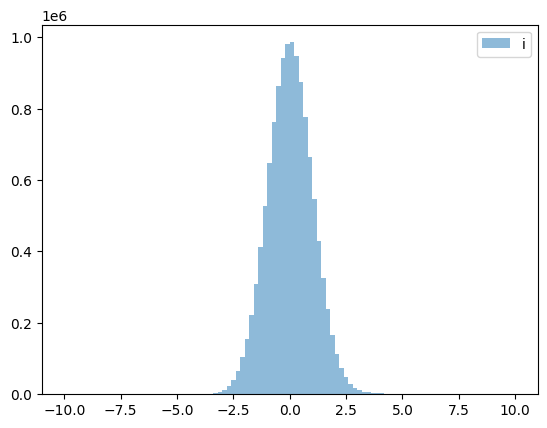

In [9]:
# Let's have a look at this distribution if we rescale each band by the standard
# deviation
for i,b in enumerate([ 'i']):
  plt.hist(cutouts[...].flatten()/scaling[i],100, label=b,alpha=0.5,
           range=[-10,10]);
legend()

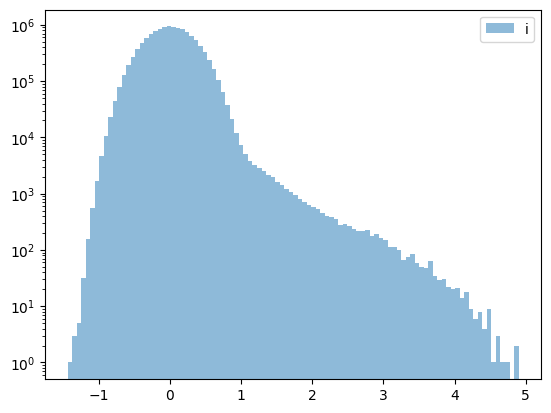

In [10]:
# a common approach for range compression is to apply arcsinh to suppress the
# high amplitude values
for i,b in enumerate(['i']):
  plt.hist(np.arcsinh(cutouts[...].flatten()/scaling[i]/3),100,
           label=b, alpha=0.5);
plt.legend()
plt.yscale('log')

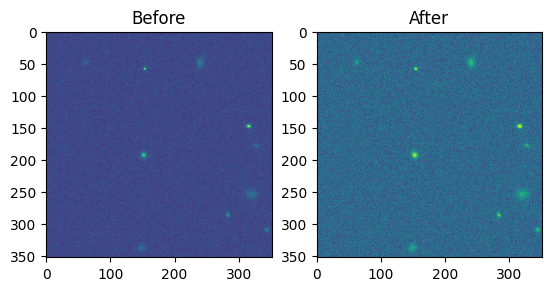

In [11]:
# we can have a look at individual postage stamps with or without this scaling
subplot(121)
imshow(cutouts[0,:,:]/scaling[0])
title('Before')
subplot(122)
imshow(np.arcsinh(cutouts[0,:,:]/scaling[0]/3))
title('After');

In [12]:
import tensorflow as tf
def preprocessing(example):
  def range_compression(img):
    return tf.clip_by_value(tf.math.asinh(tf.expand_dims(img, axis=-1) / tf.constant(scaling) / 3. ),-10,10)
  # Our preprocessing function only returns the postage stamps, and the specz
  return range_compression(example['image']), example['g']

In [13]:
batch_size = 128

# Load the data
dset = tfds.load('pisco_euclid',split='train[:80%]')
dset = dset.repeat()
dset = dset.shuffle(10000)
dset = dset.map(preprocessing)
dset = dset.batch(batch_size, drop_remainder=True)
dset = dset.prefetch(-1)
dset = dset.as_numpy_iterator()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [14]:
dset_val = tfds.load('pisco_euclid',split='train[80%:90%]')
dset_val = dset_val.repeat()
dset_val = dset_val.map(preprocessing)
dset_val = dset_val.batch(batch_size, drop_remainder=True)
dset_val = dset_val.prefetch(-1)
dset_val = dset_val.as_numpy_iterator()

In [15]:
# Define a simple MSE regression loss 
def loss_fn(params, batch):
    return jnp.mean(jnp.sum((model.apply(params, batch['x']) - batch['y'])**2,axis=-1))

@jax.jit
def update_model(params,  opt_state, batch):
  # Computes the gradients of the model
  loss, grads = jax.value_and_grad(loss_fn)(params, batch)

  # Computes the weights updates and apply them
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  return params, opt_state, loss

In [16]:
os.environ['TENSORBOARD_BINARY'] = '/net/GECO/nas12c/users/nmartinet/deeppython2/bin/tensorboard'
%load_ext tensorboard
%tensorboard --logdir=.

Reusing TensorBoard on port 6006 (pid 23879), started 23:22:28 ago. (Use '!kill 23879' to kill it.)

In [17]:
for i in tqdm.tqdm(range(total_steps)):
  batch = next(dset)
  key, seed  = jax.random.split(seed)
  batch = {'x': jnp.nan_to_num(batch[0]), 'y': batch[1]}

  # Apply the update function
  params, opt_state, loss = update_model(params, opt_state, batch)

  # Periodically exporting the value of the loss function, every 10 steps
  if i %10 == 0:
    summary_writer.scalar('train_loss', loss, i)
    summary_writer.scalar('learning_rate', lr_scheduler(i), i)
    
  # Check validation loss every 100 steps
  if i%100 == 0:
        batch = next(dset_val)
        batch = {'x': jnp.nan_to_num(batch[0]), 'y': batch[1]}
        loss_val = loss_fn(params, batch)
        summary_writer.scalar('val_loss', loss_val, i)

  # Save model parameters
  if i%1000 == 0:  
    with open('models/test_resnet18_'+str(total_steps)+'steps_temp'+str(i)+'.pckl', 'wb') as handle:
        pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('models/test_resnet18_'+str(total_steps)+'steps.pckl', 'wb') as handle:
    pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)


100%|██████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [21:28<00:00,  2.33it/s]


In [ ]:
# Read model parameters
#with open('models/test_resnet18_'+str(total_steps)+'steps.pckl', 'rb') as handle:
#    params_trained = pickle.load(handle)

In [18]:
dset_test = tfds.load('pisco_euclid',split='train[90%:]')
dset_test = dset_test.map(preprocessing)
dset_test = dset_test.batch(batch_size, drop_remainder=True)
dset_test = dset_test.prefetch(-1)
dset_test = dset_test.as_numpy_iterator()

In [19]:
preds = []
truth = []

# Applying the model
for batch in dset_test:
    preds.append(model.apply(params, jnp.nan_to_num(batch[0])))
    #preds.append(model.apply(params_trained, jnp.nan_to_num(batch[0])))
    truth.append(batch[1])
    
preds = np.concatenate(preds)
truth = np.concatenate(truth)

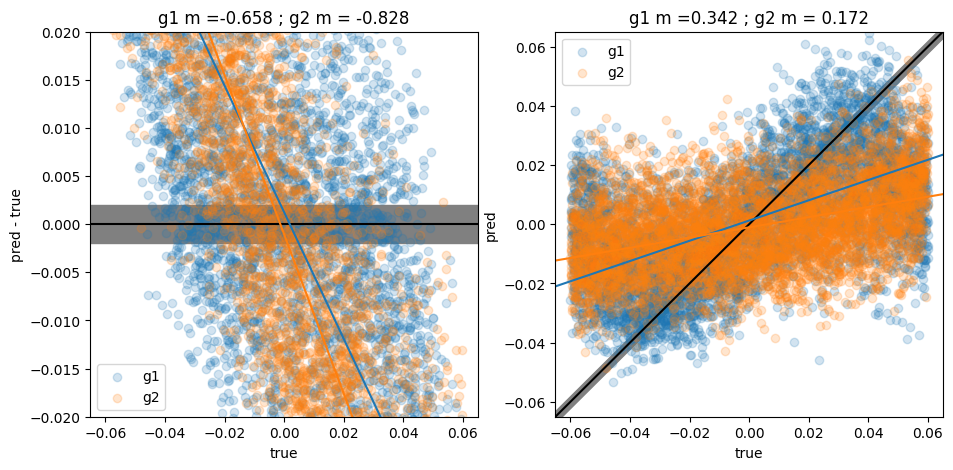

In [21]:
poly_g1 = np.polyfit(truth[:,0],preds[:,0] - truth[:,0],1)
poly_g2 = np.polyfit(truth[:,1],preds[:,1] - truth[:,1],1)

figure(figsize=(11,5))

#
subplot(121)

axhline(0, color='k')
axhspan(-0.002,0.002, color='gray');

t = linspace(-0.065,0.065)
plot(t, poly_g1[1]+poly_g1[0]*t, color='C0')
plot(t, poly_g2[1]+poly_g2[0]*t, color='C1')

scatter(truth[:,0], preds[:,0] - truth[:,0], alpha=0.2, label='g1',color='C0')
scatter(truth[:,1], preds[:,1] - truth[:,1], alpha=0.2, label='g2',color='C1')
xlabel('true')
ylabel('pred - true')

legend();
title('g1 m =%0.3f ; g2 m = %0.3f'%(poly_g1[0], poly_g2[0]))
ylim(-0.02,0.02)
xlim(-0.065,0.065)

#
subplot(122)

t = linspace(-0.065,0.065)
plot(t,t, color='k')
fill_between(t,t-0.002,t+0.002, color='gray')
plot(t, poly_g1[1]+(poly_g1[0]+1)*t, color='C0')
plot(t, poly_g2[1]+(poly_g2[0]+1)*t, color='C1')

scatter(truth[:,0], preds[:,0], alpha=0.2, label='g1',color='C0')
scatter(truth[:,1], preds[:,1], alpha=0.2, label='g2',color='C1')
xlabel('true')
ylabel('pred')

legend();
title('g1 m =%0.3f ; g2 m = %0.3f'%(poly_g1[0]+1, poly_g2[0]+1))
ylim(-0.065,0.065)
xlim(-0.065,0.065)

savefig('plots/test_resnet18_'+str(total_steps)+'steps.png')